In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics,cluster 
from umap import UMAP
import multiscale_phate as mp

import scanpy as sc
import scprep

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
adata = sc.read_h5ad('brain_embeddings.h5ad')
adata

AnnData object with n_obs × n_vars = 3210 × 18585
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_counts'
    var: 'ERCC', 'n_cells', 'n_counts', 'mean', 'std'
    uns: 'cell_ontology_class_colors', 'log1p', 'mouse.id_colors', 'neighbors', 'pca', 'plate.barcode_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
data_group = adata.obs['cell_ontology_class']
n_groups = 7
set(data_group)

{'Bergmann glial cell',
 'astrocyte',
 'brain pericyte',
 'endothelial cell',
 'neuron',
 'oligodendrocyte',
 'oligodendrocyte precursor cell'}

C:\Users\Jon\AppData\Local\Temp\ipykernel_27852\4175096173.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.16, use_weights=True)


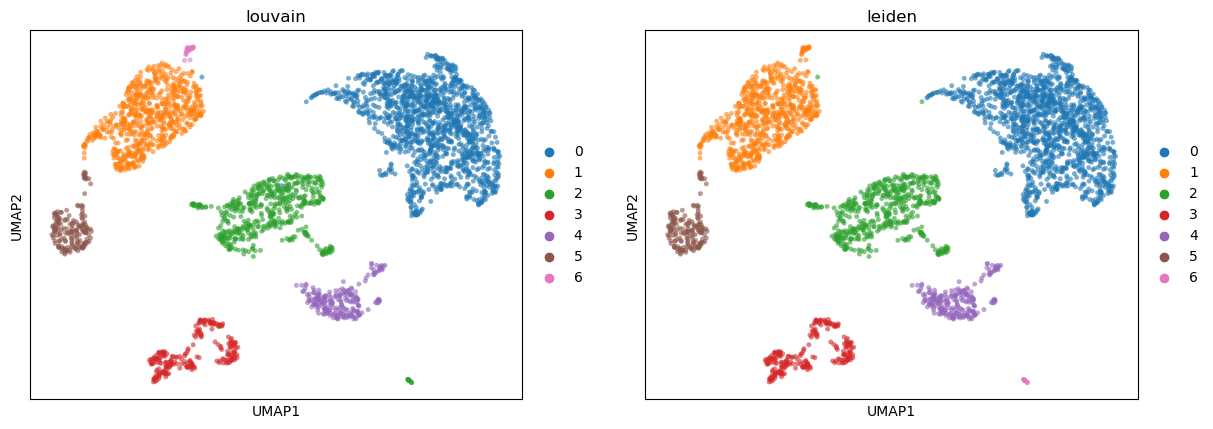

leiden: 0.9048041133454396 0.86112215351564
louvain: 0.9095149045649839 0.8711333089290303


In [4]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.16, use_weights=True)
sc.tl.louvain(adata,resolution=0.17, use_weights=True)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['louvain', 'leiden'], s=50, alpha=0.6, ncols=2)

leiden_group = np.array(adata.obs['leiden'].values).astype('int')
ari_leiden = metrics.adjusted_rand_score(leiden_group, data_group)
ami_leiden = metrics.adjusted_mutual_info_score(leiden_group, data_group)

louvain_group = np.array(adata.obs['louvain'].values).astype('int')
ari_louvain = metrics.adjusted_rand_score(louvain_group, data_group)
ami_louvain = metrics.adjusted_mutual_info_score(louvain_group, data_group)

print("leiden:",ari_leiden,ami_leiden)
print("louvain:",ari_louvain,ami_louvain)

In [5]:
from dtne import *

In [6]:
X = adata.obsm['X_pca']

In [7]:
embedding = DTNE(k_neighbors = 10) 
Y = embedding.fit_transform(X)
dtne_cluster = embedding.cluster_cells(n_clusters=n_groups)

ari_dtne = metrics.adjusted_rand_score(dtne_cluster, data_group)
ami_dtne = metrics.adjusted_mutual_info_score(dtne_cluster, data_group)
print("dtne:",ari_dtne,ami_dtne)

dtne: 0.9025595681689959 0.8689326872600356


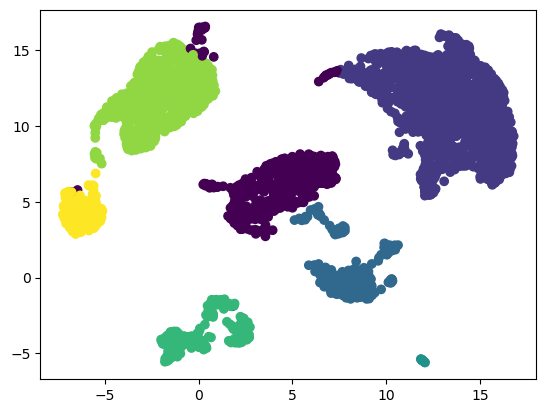

In [8]:
plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],c=dtne_cluster)

In [9]:
set(leiden_group)

{0, 1, 2, 3, 4, 5, 6}

In [10]:
agglo_instance = cluster.AgglomerativeClustering(n_clusters=n_groups).fit(X)
agglo_groups = agglo_instance.labels_
ari_agglo = metrics.adjusted_rand_score(agglo_groups, data_group)
ami_agglo = metrics.adjusted_mutual_info_score(agglo_groups, data_group)

print("hierarchical:",ari_agglo,ami_agglo)

hierarchical: 0.8610320683193746 0.8110771911100537


{0, 1, 2, 3, 4, 5, 6}
dtne: 0.9059810003636717 0.8575320007299791


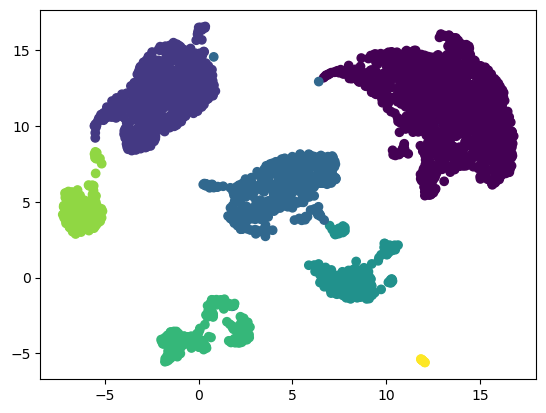

In [11]:
# embedding = DTNE(k_neighbors = 10) 
# Y = embedding.fit_transform(X)
dtne_cluster_louvain = embedding.cluster_cells(n_clusters=n_groups,cluster_method = 'louvain',resolution=0.06, use_weights=True)
print(set(dtne_cluster_louvain))
plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],c=dtne_cluster_louvain)

ari_dtne_louvain = metrics.adjusted_rand_score(dtne_cluster_louvain, data_group)
ami_dtne_louvain = metrics.adjusted_mutual_info_score(dtne_cluster_louvain, data_group)
print("dtne:",ari_dtne_louvain,ami_dtne_louvain)

{0, 1, 2, 3, 4, 5, 6}
dtne: 0.9081322412269004 0.8633866685145608


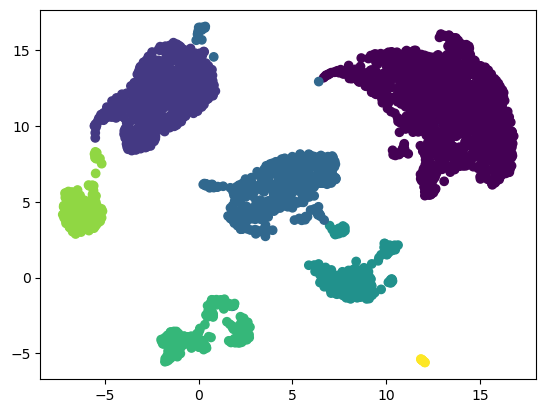

In [12]:
dtne_cluster_leiden = embedding.cluster_cells(n_clusters=n_groups,cluster_method = 'leiden',resolution=0.08, use_weights=True)
print(set(dtne_cluster_leiden))
plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],c=dtne_cluster_leiden)

ari_dtne_leiden = metrics.adjusted_rand_score(dtne_cluster_leiden, data_group)
ami_dtne_leiden = metrics.adjusted_mutual_info_score(dtne_cluster_leiden, data_group)
print("dtne:",ari_dtne_leiden,ami_dtne_leiden)

In [13]:
mp_op = mp.Multiscale_PHATE(random_state=0)
levels = mp_op.fit(X)
levels

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculating diffusion potential...
  Calculated diffusion potential in 4.41 seconds.
  Setting epsilon to 0.4455
  Setting merge threshold to 0.168
  Calculating condensation...
  Calculated condensation in 7.30 seconds.
Calculated Multiscale PHATE tree in 11.77 seconds.
Computing gradient...
Identifying salient levels of resolution...


[0, 4, 6, 143, 152, 166, 171, 182, 187, 199]

In [14]:
mp_embedding, mp_clusters, mp_sizes = mp_op.transform(visualization_level = 0,cluster_level = 171)
set(mp_clusters)

{0, 3, 7, 32, 45, 48, 59, 74, 499}

In [15]:
ari_mp = metrics.adjusted_rand_score(mp_clusters, data_group)
ami_mp = metrics.adjusted_mutual_info_score(mp_clusters, data_group)
print("Multiscale PHATE:",ari_mp,ami_mp)

Multiscale PHATE: 0.17716348745504112 0.3471300912492266


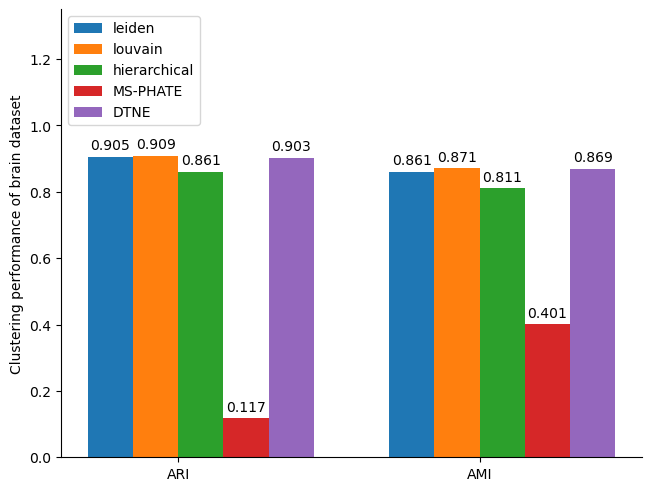

In [16]:
correlation = ['ARI','AMI']
pseudotime_corr = {
    'leiden':(0.905, 0.861),
    'louvain':(0.909, 0.871),
    'hierarchical':(0.861, 0.811),
    'MS-PHATE':(0.117, 0.401),
    'DTNE':(0.903, 0.869)
    }

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, corr, width, label=name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Clustering performance of brain dataset')
ax.set_xticks(x + 1.5*width, correlation)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 1.35)

sns.despine(top=True,right=True,left=False,bottom=False,)
# ax.grid(False)
# ax.tick_params(bottom=True, left=True)

plt.savefig('./brain_plot.png', format='png', dpi=1000)
plt.savefig('./brain_plot.pdf', format='pdf', dpi=1000)